<a href="https://colab.research.google.com/github/Qiqi-0810/Drivable_area/blob/main/MDSNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.5.0 and CUDA 10.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/mmsegmentation

/content/drive/MyDrive/Colab Notebooks/mmsegmentation


In [ ]:
# Install PyTorch
!pip install -U torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full==latest+torch1.5.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8MB 19kB/s 
     |████████████████████████████████| 6.6MB 87.3MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
Looking in links: https://download.openmmlab.com/mmcv/dist/index.html
     |████████████████████████████████| 27.5MB 1.0MB/s 
     |████████████████████████████████| 194kB 4.3MB/s 


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.5.0+cu101 True
0.12.0


## Run Inference with MMSeg trained weight

In [ ]:
!pip install terminaltables

  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=0f099a3b95b41d96f853dfb2446f516dbbae6dd367a791d88fad0464ec05d5ff
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette ##？？

In [ ]:
config_file = 'configs/repsp/repsp_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [ ]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
#print(model)

Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for decode_head.bottleneck.conv.weight: copying a param with shape torch.Size([512, 4096, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 9216, 3, 3]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
missing keys in source state_dict: decode_head.global_info0.conv

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are neccessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same perfix. To support a new dataset, we may need to modify the original file structure. 

In [ ]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

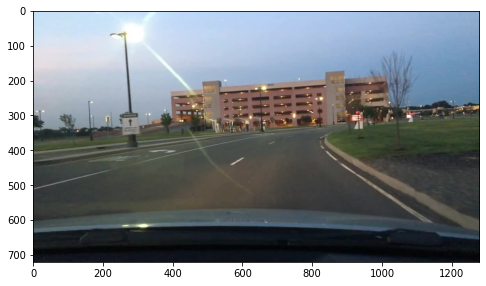

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/Colab Notebooks/bdd100k/images/0000f77c-62c2a288.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

For later use, here are some args

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '/content/drive/MyDrive/Colab Notebooks/bdd100k/'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('background', 'drivable_areas', 'alternatively_drivable_areas')
palette = [[0, 0, 0], [255, 0, 0], [0, 0, 255]]

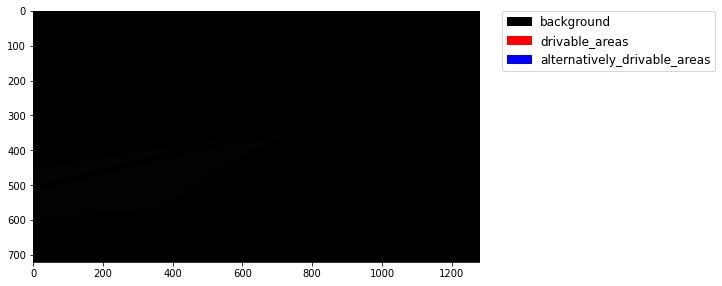

In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/content/drive/MyDrive/Colab Notebooks/bdd100k/labels/0000f77c-62c2a288.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [ ]:
# split train/val set as txt/files?
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))

In [ ]:

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class QiqiDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/repsp/repsp_r50-d8_512x1024_40k_cityscapes.py')

Since the given config is used to train PSPNet on cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [ ]:
from mmseg.apis import set_random_seed

#cfg.model.backbone.dilations = (1, 2, 5, 1)
#cfg.model.decode_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[0.152275332, 1, 1.398393334])###Mean
#cfg.model.auxiliary_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4, class_weight=[0.152275332, 1, 1.398393334])
cfg.model.decode_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[0.916721204, 1, 1.793533931])##instance
cfg.model.auxiliary_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4, class_weight=[0.916721204, 1, 1.793533931])
#cfg.model.decode_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[0.139594026, 1, 2.508065893])###pixel
#cfg.model.auxiliary_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4, class_weight=[0.139594026, 1, 2.508065893])
cfg.model.decode_head.sampler = dict(type='OHEMPixelSampler', thresh = 0.7, min_kept=100000)##
#cfg.model.decode_head.loss_decode = dict(type='LovaszLoss', loss_type='multi_class', classes='present', per_image=False, reduction='none', loss_weight=1.0)###
#cfg.model.auxiliary_head.loss_decode = dict(type='LovaszLoss', loss_type='multi_class', classes='present', per_image=False, reduction='none', loss_weight=0.4)###
cfg.optimizer=dict(type='Adam', lr=0.0001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.0005, amsgrad=False, paramwise_cfg = dict(customs_keys={'head':dict(lr_mult=10.)}))

# Modify dataset type and path
cfg.dataset_type = 'QiqiDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 16 ###
cfg.data.workers_per_gpu = 8 ###

cfg.img_norm_cfg = dict(mean=[75.32, 78.63, 77.82], std=[65.15, 69.25, 71.95], to_rgb=True)
#cfg.img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1280, 720), ratio_range=(0.5, 2.0)),###image_scale
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1280, 720),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train10000_all.txt'###

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
#cfg.data.val.split = 'splits/val1000_all.txt'###
#cfg.data.val.split = 'splits/Night_val.txt'###
#cfg.data.val.split = 'splits/Day_val.txt'###
#cfg.data.val.split = 'splits/Rain_val.txt'###
#cfg.data.val.split = 'splits/Snow_val.txt'###
#cfg.data.val.split = 'splits/Sunny_val.txt'###
#cfg.data.val.split = 'splits/Cloud_val.txt'###
#cfg.data.val.split = 'splits/unstructured_val.txt'###
cfg.data.val.split = 'splits/Structured_val.txt'###

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/test_all.txt'###

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
cfg.resume_from = '/content/drive/MyDrive/Colab Notebooks/mmsegmentation/work_dirs/tutorial/iter_15000.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.total_iters = 200 ###
cfg.log_config.interval = 10  ###
cfg.evaluation.interval = 10 ####
cfg.checkpoint_config.interval = 10###
cfg.runner.max_iters = 15010 ###
cfg.lr_config = dict(policy='poly', power=0.9, min_lr=1e-9, by_epoch=False)
cfg.workflow = [('train',1), ('val',1)]
#cfg.runner = dict(type='EpochBasedRunner', max_epochs=10) # Total number of iterations. For EpochBasedRunner use `max_epochs`

#cfg.optimizer=dict(type='SGD', lr=0.0001, momentum=0.9, weight_decay=0.0001, paramwise_cfg = dict(customs_keys={'head':dict(lr_mult=10.)}))
#### Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='REPSPHead',
        in_channels=[256, 512, 1024, 2048],
        in_index=(0, 1, 2, 3),
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=False,
            loss_weight=1.0,
            class_weight=[0.916721204, 1, 1.793533931]),
        input_transform='multiple_select',
       

### Train and Evaluation

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

import copy

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

if len(cfg.workflow) == 2:
  val_dataset = copy.deepcopy(cfg.data.val)
  val_dataset.pipeline = cfg.data.train.pipeline
  datasets.append(build_dataset(val_dataset))

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-05-07 09:04:58,555 - mmseg - INFO - Loaded 10000 images
2021-05-07 09:04:59,048 - mmseg - INFO - Loaded 1295 images
2021-05-07 09:04:59,904 - mmseg - INFO - Use load_from_openmmlab loader
2021-05-07 09:04:59,968 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-05-07 09:05:00,074 - mmseg - INFO - Loaded 1295 images
2021-05-07 09:05:00,076 - mmseg - INFO - load checkpoint from /content/drive/MyDrive/Colab Notebooks/mmsegmentation/work_dirs/tutorial/iter_15000.pth
2021-05-07 09:05:00,077 - mmseg - INFO - Use load_from_local loader
2021-05-07 09:05:01,416 - mmseg - INFO - resumed from epoch: 5, iter 15000
2021-05-07 09:05:01,418 - mmseg - INFO - Start running, host: root@4f34591179d9, work_dir: /content/driv

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1295/1295, 3.9 task/s, elapsed: 336s, ETA:     0s

2021-05-07 09:11:56,442 - mmseg - INFO - per class results:
2021-05-07 09:11:56,444 - mmseg - INFO - 
+------------------------------+-------+-------+
| Class                        | IoU   | Acc   |
+------------------------------+-------+-------+
| background                   | 94.82 | 95.76 |
| drivable_areas               | 70.86 | 84.13 |
| alternatively_drivable_areas | 54.9  | 84.42 |
+------------------------------+-------+-------+
2021-05-07 09:11:56,445 - mmseg - INFO - Summary:
2021-05-07 09:11:56,446 - mmseg - INFO - 
+--------+-------+------+-------+
| Scope  | mIoU  | mAcc | aAcc  |
+--------+-------+------+-------+
| global | 73.53 | 88.1 | 93.89 |
+--------+-------+------+-------+
2021-05-07 09:12:17,668 - mmseg - INFO - Iter(val) [15010]	mIoU: 0.7353, mAcc: 0.8810, aAcc: 0.9389, IoU.background: 0.9482, IoU.drivable_areas: 0.7086, IoU.alternatively_drivable_areas: 0.5490, Acc.background: 0.9576, Acc.drivable_areas: 0.8413, Acc.alternatively_drivable_areas: 0.8442


In [ ]:
#configs/repsp/repsp_r50-d8_512x1024_40k_cityscapes.py
!python test.py configs/repsp/repsp_r50-d8_512x1024_40k_cityscapes.py work_dirs/tutorial/iter_150.pth --show-dir reda_results

Inference with trained model

/content/drive/My Drive/Colab Notebooks/mmsegmentation/mmseg/models/segmentors/base.py:283: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

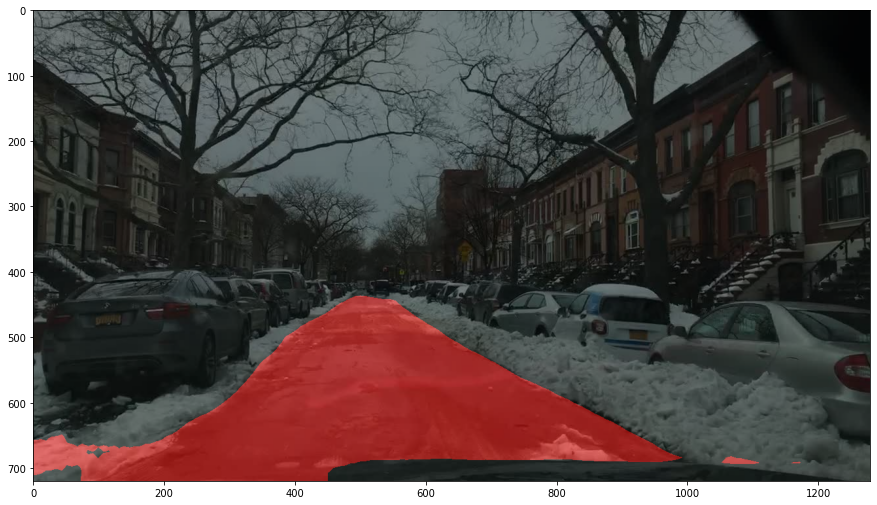

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/Colab Notebooks/bdd100k/images/cdd7d07d-1741c8b0.jpg')###
# 8680 102052 b1cebfb7-284f5117 47988 134664 136648 cae8e3d7-13803eef cc7ffc6e-f529b6b6 
# / cabc30fc-eb673c5a cba301b8-7ef6e928 cc27a12a-692adf76 cd620b50-8f9fc451 cdd7d07d-1741c8b0 25916 128216
#night b1c81faa-3df17267 b1d10d08-743fd86c b1ebfc3c-740ec84a b1e88fd2-c1e4fd2b b1f6c103-5ce1f3c6 b2d4c878-2267ca6d b2d3510a-659ae4de
#rain b4e927af-828f4a9b b4b7133e-5672ca28 b9c9d815-3f9d9a8a
#snow b2d8704e-66d10551 b8a135c9-8c38e7ba cdd7d07d-1741c8b0
model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)